# Finding duplicated images with Sentence Transformers

SentenceTransformers provides models that allow to embed images and text into the same vector space. This allows to find similar images as well as to implement image search. We can also try to detect perfect duplicates from a collection of images or find similar images.

https://www.sbert.net/examples/applications/image-search/README.html

## 1. Settings

In [1]:
#!pip install sentence_transformers

In [2]:
#!pip install ftfy

In [3]:
import glob
import torch
import os
import time
import json
import humanize
import sys
import datetime

from PIL import Image
from IPython.display import display
from IPython.display import Image as IPDImage
from tqdm.autonotebook import tqdm

from sentence_transformers import SentenceTransformer, util

In [4]:
print("Torch version:", torch.__version__)
assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.8.1+cu102


In [5]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [6]:
print('Today: ' + str(datetime.datetime.today().strftime ('%d-%b-%Y')))

Today: 21-Sep-2022


## 2. Images

In [7]:
img_folder = 'images'

In [8]:
nbfiles = sum(len(files) for _, _, files in os.walk(img_folder))
print("Number of files in the directory:", img_folder, "=", nbfiles)

Number of files in the directory: images = 20


In [9]:
imageslist = [file for file in glob.glob(img_folder + '/*.*') 
              if file.endswith(('jpeg', 'png', 'jpg', 'JPEG', 'PNG', 'JPG'))]

In [10]:
imageslist

['images/image (1).jpg',
 'images/image (10).jpg',
 'images/image (11).jpg',
 'images/image (12).jpg',
 'images/image (13).jpg',
 'images/image (14).jpg',
 'images/image (15).jpg',
 'images/image (16).jpg',
 'images/image (17).jpg',
 'images/image (18).jpg',
 'images/image (19).jpg',
 'images/image (2).jpg',
 'images/image (20).jpg',
 'images/image (3).jpg',
 'images/image (4).jpg',
 'images/image (5).jpg',
 'images/image (6).jpg',
 'images/image (7).jpg',
 'images/image (8).jpg',
 'images/image (9).jpg']

In [11]:
len(imageslist)

20

In [12]:
def image_view(index):
    print(imageslist[index])
    display(IPDImage(imageslist[index], width=200))

images/image (1).jpg


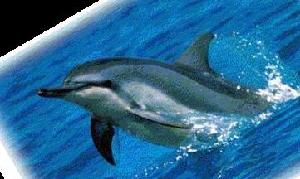

In [13]:
image_view(0)

images/image (10).jpg


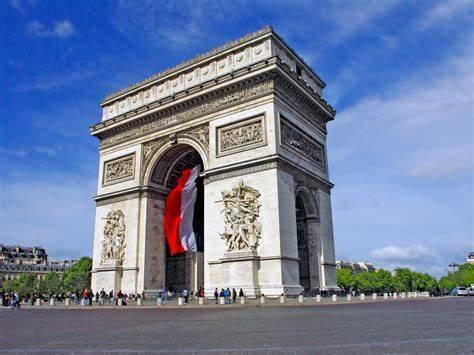

In [14]:
image_view(1)

images/image (14).jpg


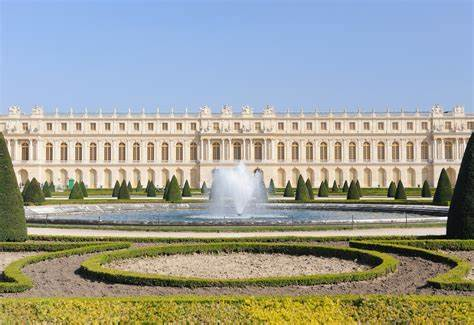

In [15]:
image_view(5)

images/image (19).jpg


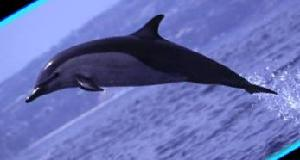

In [16]:
image_view(10)

images/image (5).jpg


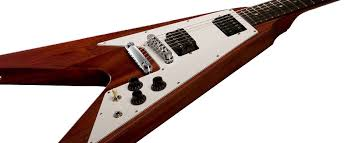

In [17]:
image_view(15)

## 3. Model specification and Images embedding

Now we can specify a CLIP model to use and we will apply it to all our images
- https://www.sbert.net/docs/pretrained_models.html#image-text-models
- https://huggingface.co/sentence-transformers/clip-ViT-B-32

In [18]:
clipmodel = 'clip-ViT-B-16'

model = SentenceTransformer(clipmodel)
print("We will use model:", clipmodel)

We will use model: clip-ViT-B-16


Now it is time to process all the images

In [19]:
print("Processing images using", clipmodel, "...") # We are going to encode each image file

t1 = time.time()
image_emb = model.encode([Image.open(filename) for filename in imageslist],
                         batch_size=64,
                         convert_to_tensor=True,
                         show_progress_bar=True)

print("\nDone in", round(time.time() - t1, 5), "seconds")

Processing images using clip-ViT-B-16 ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Done in 3.13365 seconds


## 4. Duplicates

In [20]:
duplicates = util.paraphrase_mining_embeddings(image_emb)

In [21]:
# Quick preview of the duplicates results
print("score, image index 1, image index 2")
duplicates[:10]

score, image index 1, image index 2


[[1.0000001192092896, 15, 16],
 [1.0000001192092896, 18, 19],
 [1.0, 4, 5],
 [1.0, 4, 6],
 [1.0, 5, 6],
 [1.0, 8, 9],
 [0.9999998807907104, 13, 14],
 [0.9999998211860657, 1, 3],
 [0.9803495407104492, 1, 2],
 [0.9803495407104492, 2, 3]]

In [22]:
def find_duplicates(imgsize=200):

    t1 = time.time()
    index0 = 0
    duplicates_list = []

    print("\033[1;31;34mSearching images duplicates...\n")

    while duplicates[index0][0] >= 0.99: # Strictly identical images

        score = duplicates[index0][0]
        index1 = duplicates[index0][1]
        image1 = imageslist[index1]
        index2 = duplicates[index0][2]
        image2 = imageslist[index2]

        print("*" * 20, "Duplicate #", index0 + 1, "*" * 20, "\n")
        print("\033[1;31;32mBoth images are duplicates:")
        print(image1, "and", image2)
        
        print("\n\033[1;31;34m", image1)
        display(IPDImage(image1, width=imgsize))

        print("\033[1;31;34m", image2)
        display(IPDImage(image2, width=imgsize))

        duplicates_list.append(imageslist[index1])
        duplicates_list.append(imageslist[index2])        
        
        filedate1 = time.ctime(os.path.getmtime(image1))
        filesize1 = os.path.getsize(image1)
        filedate2 = time.ctime(os.path.getmtime(image2))
        filesize2 = os.path.getsize(image2)
        print()
        print(image1, "| size =", humanize.naturalsize(filesize1), "| date :", filedate1)
        print(image2, "| size =", humanize.naturalsize(filesize2), "| date :", filedate2)
        
        print("\n\033[1;31;34m")

        index0 += 1

    print("\033[1;31;32mTotal number of duplicated images =", index0)
    print("\n\033[0mDone in", round(time.time() - t1, 5), "seconds")

    return duplicates_list

### Finding all duplicated images...

In [23]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

Searching images duplicates...

******************** Duplicate # 1 ******************** 

Both images are duplicates:
images/image (5).jpg and images/image (6).jpg

 images/image (5).jpg


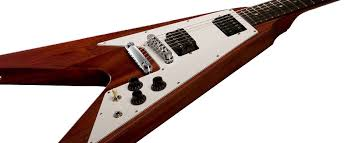

 images/image (6).jpg


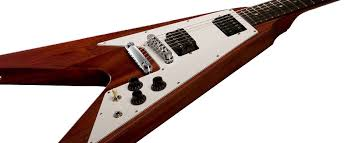


images/image (5).jpg | size = 7.0 kB | date : Wed Sep 21 08:52:44 2022
images/image (6).jpg | size = 7.0 kB | date : Wed Sep 21 08:52:37 2022


******************** Duplicate # 2 ******************** 

Both images are duplicates:
images/image (8).jpg and images/image (9).jpg

 images/image (8).jpg


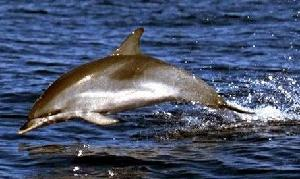

 images/image (9).jpg


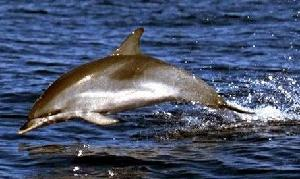


images/image (8).jpg | size = 22.1 kB | date : Wed Sep 21 08:52:32 2022
images/image (9).jpg | size = 15.6 kB | date : Wed Sep 21 08:52:42 2022


******************** Duplicate # 3 ******************** 

Both images are duplicates:
images/image (13).jpg and images/image (14).jpg

 images/image (13).jpg


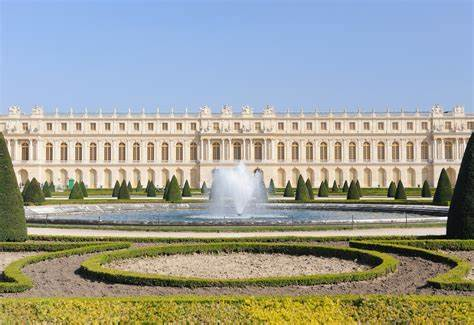

 images/image (14).jpg


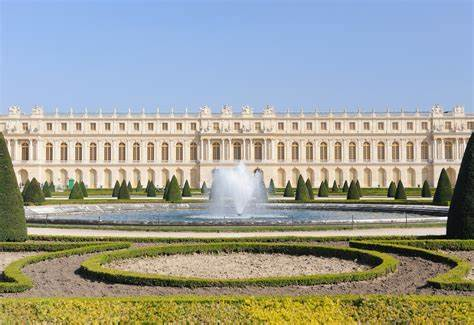


images/image (13).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:33 2022
images/image (14).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:40 2022


******************** Duplicate # 4 ******************** 

Both images are duplicates:
images/image (13).jpg and images/image (15).jpg

 images/image (13).jpg


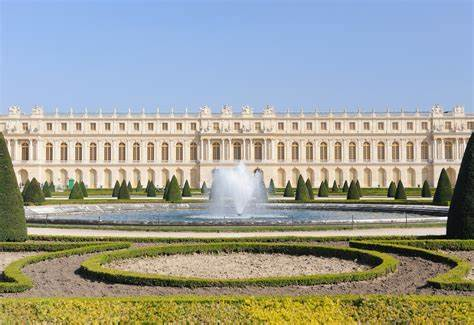

 images/image (15).jpg


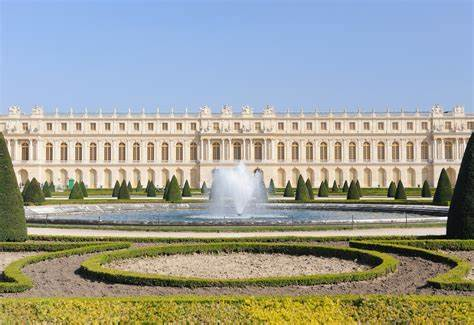


images/image (13).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:33 2022
images/image (15).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:35 2022


******************** Duplicate # 5 ******************** 

Both images are duplicates:
images/image (14).jpg and images/image (15).jpg

 images/image (14).jpg


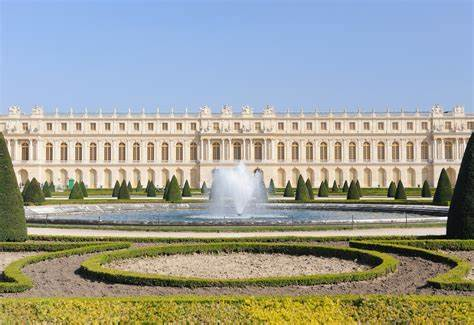

 images/image (15).jpg


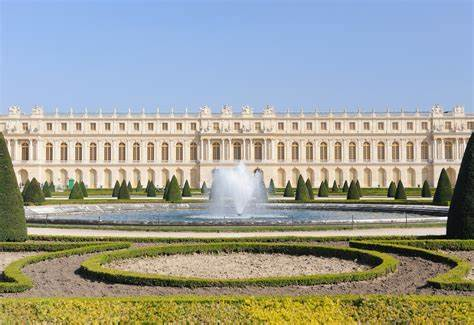


images/image (14).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:40 2022
images/image (15).jpg | size = 30.7 kB | date : Wed Sep 21 08:52:35 2022


******************** Duplicate # 6 ******************** 

Both images are duplicates:
images/image (17).jpg and images/image (18).jpg

 images/image (17).jpg


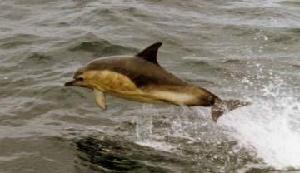

 images/image (18).jpg


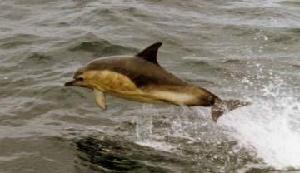


images/image (17).jpg | size = 10.6 kB | date : Wed Sep 21 08:52:40 2022
images/image (18).jpg | size = 10.6 kB | date : Wed Sep 21 08:52:30 2022


******************** Duplicate # 7 ******************** 

Both images are duplicates:
images/image (3).jpg and images/image (4).jpg

 images/image (3).jpg


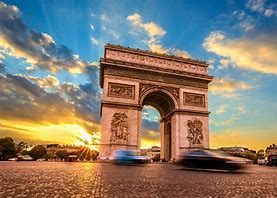

 images/image (4).jpg


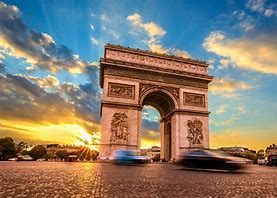


images/image (3).jpg | size = 15.9 kB | date : Wed Sep 21 08:52:38 2022
images/image (4).jpg | size = 15.9 kB | date : Wed Sep 21 08:52:37 2022


******************** Duplicate # 8 ******************** 

Both images are duplicates:
images/image (10).jpg and images/image (12).jpg

 images/image (10).jpg


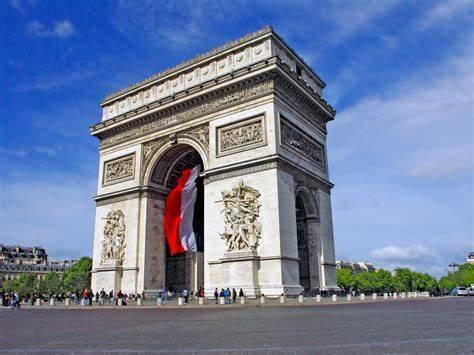

 images/image (12).jpg


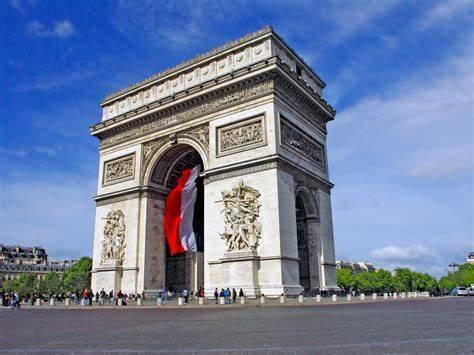


images/image (10).jpg | size = 29.8 kB | date : Wed Sep 21 08:52:36 2022
images/image (12).jpg | size = 29.8 kB | date : Wed Sep 21 08:52:44 2022


Total number of duplicated images = 8

Done in 0.46841 seconds


['images/image (5).jpg',
 'images/image (6).jpg',
 'images/image (8).jpg',
 'images/image (9).jpg',
 'images/image (13).jpg',
 'images/image (14).jpg',
 'images/image (13).jpg',
 'images/image (15).jpg',
 'images/image (14).jpg',
 'images/image (15).jpg',
 'images/image (17).jpg',
 'images/image (18).jpg',
 'images/image (3).jpg',
 'images/image (4).jpg',
 'images/image (10).jpg',
 'images/image (12).jpg']

In [24]:
find_duplicates()

## 5. Finding all similar images

In [25]:
def find_near_duplicates(miscore = 0.95):

    t1 = time.time()

    threshold = 0.99
    near_duplicates = [entry for entry in duplicates if entry[0] < threshold]

    print("\033[1;31;34mFinding similar images with minimum similarity score =", miscore, "\n")
    index0 = 0
    
    near_duplicates_list = []

    while near_duplicates[index0][0] >= miscore: # similarity score

        score = near_duplicates[index0][0]
        index1 = near_duplicates[index0][1]
        image1 = imageslist[index1]
        index2 = near_duplicates[index0][2]
        image2 = imageslist[index2]

        print("\033[1;31;34m")
        print("*" * 60)
        print("\n                Near duplicate image number", index0 + 1, "\n")
        print("*" * 60)

        print("\n\033[1;31;34mImage filename:", imageslist[index1])
        display(IPDImage(imageslist[index1], width=200))

        print("\033[1;31;34mImage filename:", imageslist[index2])
        display(IPDImage(imageslist[index2], width=200))

        print("\033[1;31;32m\nSimilarity score =", round(score, 5), 
              "\nbetween", imageslist[index1],
              "and", imageslist[index2],
              "\n")

        index0 += 1

        near_duplicates_list.append(imageslist[index1])
        near_duplicates_list.append(imageslist[index2])

    print("\n\033[0mDone in", round(time.time() - t1, 5), "seconds")

    return near_duplicates_list

### Test 1

Finding similar images with minimum similarity score = 0.93 


************************************************************

                Near duplicate image number 1 

************************************************************

Image filename: images/image (10).jpg


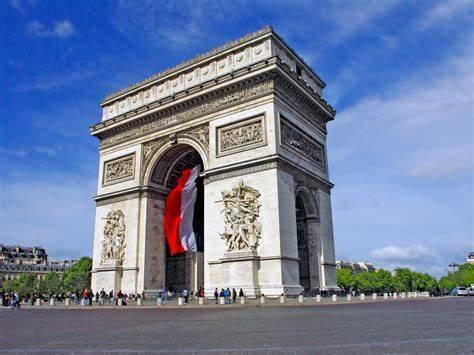

Image filename: images/image (11).jpg


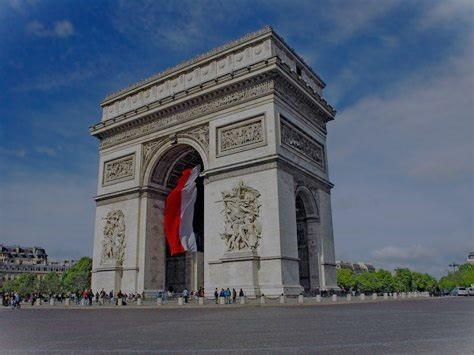


Similarity score = 0.98035 
between images/image (10).jpg and images/image (11).jpg 


************************************************************

                Near duplicate image number 2 

************************************************************

Image filename: images/image (11).jpg


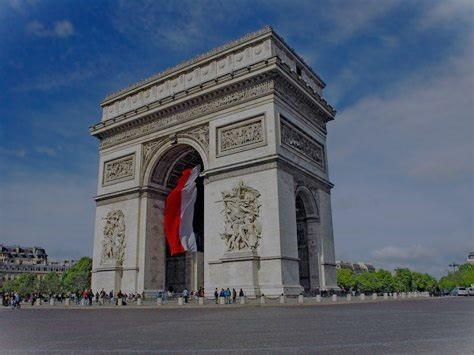

Image filename: images/image (12).jpg


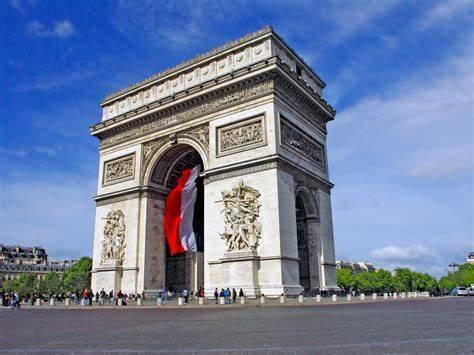


Similarity score = 0.98035 
between images/image (11).jpg and images/image (12).jpg 


************************************************************

                Near duplicate image number 3 

************************************************************

Image filename: images/image (2).jpg


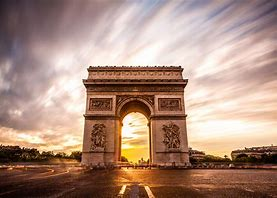

Image filename: images/image (3).jpg


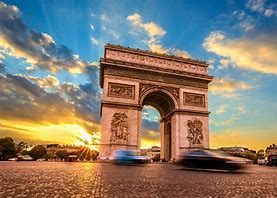


Similarity score = 0.96378 
between images/image (2).jpg and images/image (3).jpg 


************************************************************

                Near duplicate image number 4 

************************************************************

Image filename: images/image (2).jpg


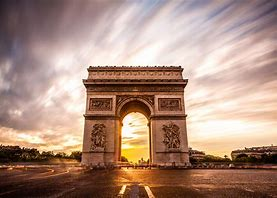

Image filename: images/image (4).jpg


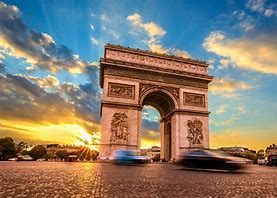


Similarity score = 0.96378 
between images/image (2).jpg and images/image (4).jpg 


Done in 0.21957 seconds


['images/image (10).jpg',
 'images/image (11).jpg',
 'images/image (11).jpg',
 'images/image (12).jpg',
 'images/image (2).jpg',
 'images/image (3).jpg',
 'images/image (2).jpg',
 'images/image (4).jpg']

In [26]:
find_near_duplicates(0.93)

### Test 2

Finding similar images with minimum similarity score = 0.9 


************************************************************

                Near duplicate image number 1 

************************************************************

Image filename: images/image (10).jpg


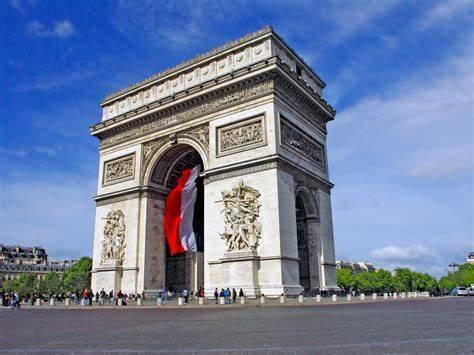

Image filename: images/image (11).jpg


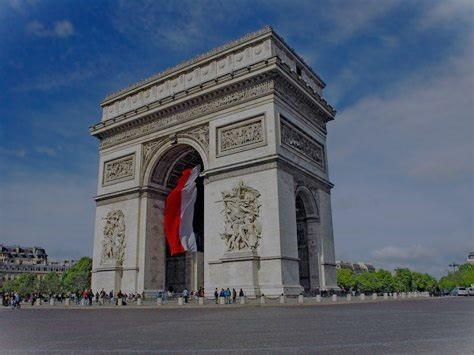


Similarity score = 0.98035 
between images/image (10).jpg and images/image (11).jpg 


************************************************************

                Near duplicate image number 2 

************************************************************

Image filename: images/image (11).jpg


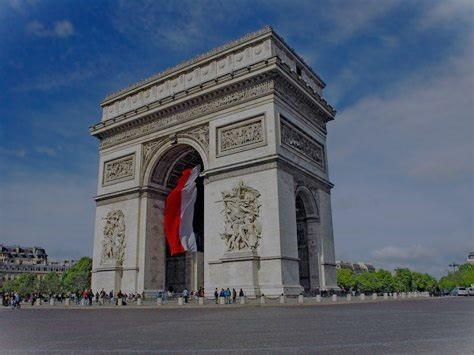

Image filename: images/image (12).jpg


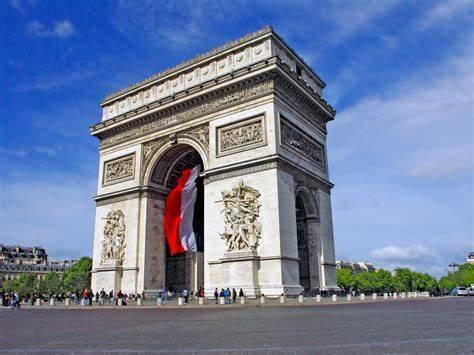


Similarity score = 0.98035 
between images/image (11).jpg and images/image (12).jpg 


************************************************************

                Near duplicate image number 3 

************************************************************

Image filename: images/image (2).jpg


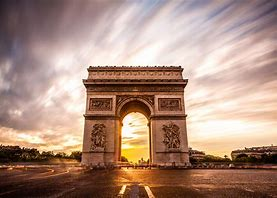

Image filename: images/image (3).jpg


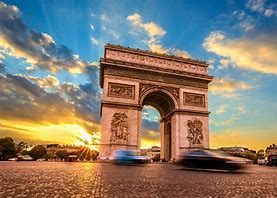


Similarity score = 0.96378 
between images/image (2).jpg and images/image (3).jpg 


************************************************************

                Near duplicate image number 4 

************************************************************

Image filename: images/image (2).jpg


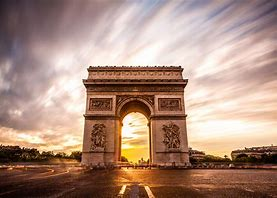

Image filename: images/image (4).jpg


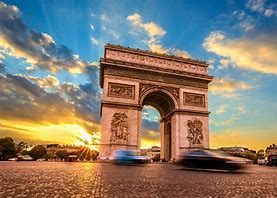


Similarity score = 0.96378 
between images/image (2).jpg and images/image (4).jpg 


************************************************************

                Near duplicate image number 5 

************************************************************

Image filename: images/image (1).jpg


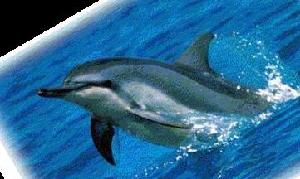

Image filename: images/image (19).jpg


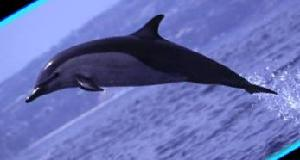


Similarity score = 0.91655 
between images/image (1).jpg and images/image (19).jpg 


Done in 0.28619 seconds


['images/image (10).jpg',
 'images/image (11).jpg',
 'images/image (11).jpg',
 'images/image (12).jpg',
 'images/image (2).jpg',
 'images/image (3).jpg',
 'images/image (2).jpg',
 'images/image (4).jpg',
 'images/image (1).jpg',
 'images/image (19).jpg']

In [27]:
find_near_duplicates(0.9)